# SARSA application to extended windy gridworld 

Application of SARSA algorithm to the stochastic windy-gridworld environment. Resolution of the 6.6 exercise, consisting on modifying the original problem definition so that oblicuous and recurrent moves (no moving) are allowed as well as stochastic wind is applied.

In [1]:
import gym
# Install gym_gridworlds from @podondra
# Option 1: pip install gym_gridworlds
# Option 2: https://github.com/podondra/gym-gridworlds
import gym_gridworlds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import clear_output

In [2]:
class SarsaAgent:
    def __init__(self, alpha, epsilon = 0.1, gamma=0.9):
        self.state_action_value = {}
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_actions=9
    
    def get_q_value(self, s, a):
        if not s in self.state_action_value:
            self.state_action_value[s] = {}
        
        if not a in self.state_action_value[s]:
            self.state_action_value[s][a] = random.random()
        
        return self.state_action_value[s][a]
    
    def set_q_value(self, s, a, value):
        if not s in self.state_action_value:
            self.state_action_value[s] = {}
        
        self.state_action_value[s][a] = value
        
    def update_q_values(self, s ,a ,r ,s_prime, a_prime):
        current_q_value = self.get_q_value(s, a)
        td_error = r + self.gamma*self.get_q_value(s_prime, a_prime) - current_q_value
        update = self.alpha*td_error
        new_q_value = current_q_value + update
        self.set_q_value(s, a, new_q_value)
        return update
        
    def get_action(self, state):
        if not state in self.state_action_value:
            return random.randint(0,self.n_actions-1)
        # epsilon greedy
        if random.random() > self.epsilon:
            return max(self.state_action_value[state].items(), key=lambda x:x[1])[0]
        else:
            return random.randint(0,self.n_actions-1)
        

In [3]:
env = gym.make("StochasticWindyGridworld-v0")
agent = SarsaAgent(alpha = 0.05, epsilon = 0.1)
episodes=0
max_actions=75
updates=[]
returns=[]
total_actions=[]

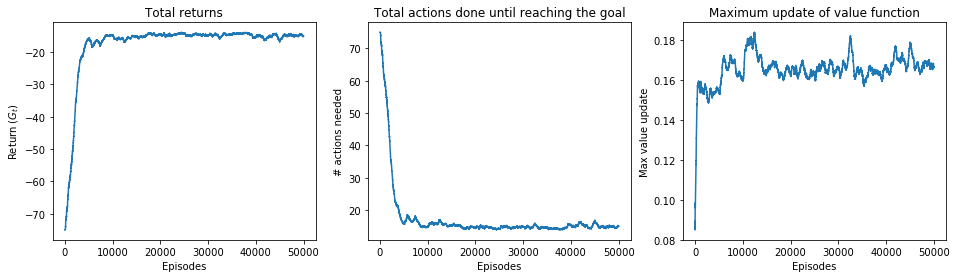

Actions needed: 14.7776


In [4]:
# Run the episodes and adjust the SARSA agent
while episodes < 50000:
    updates.append(0)
    returns.append(0)

    episodes+=1
    state = env.reset()
    action = agent.get_action(state)
    done=False
    c=0
    
    while (done==False) and (c<max_actions):
        c+=1
        state_prime, reward, done, _ = env.step(action)
        action_prime = agent.get_action(state_prime)
        upd=agent.update_q_values(state, action, reward, state_prime, action_prime)
        state, action = state_prime, action_prime
        returns[-1]+=reward
        if updates[-1] < abs(upd):
            updates[-1] = abs(upd)
    total_actions.append(c)
    if c < max_actions:
        assert done==True
    if episodes %1000 ==0:
        clear_output(True)
        plt.figure(figsize=(16, 4))
        plt.subplot(131)
        plt.plot(pd.Series(returns).ewm(span=1000).mean())
        plt.title("Total returns")
        plt.xlabel("Episodes")
        plt.ylabel("Return ($G_t$)")
        plt.subplot(132)
        plt.plot(pd.Series(total_actions).ewm(span=1000).mean())
        plt.title("Total actions done until reaching the goal")
        plt.xlabel("Episodes")
        plt.ylabel("# actions needed")
        plt.subplot(133)
        plt.plot(pd.Series(updates).ewm(span=1000).mean())
        plt.title("Maximum update of value function")
        plt.xlabel("Episodes")
        plt.ylabel("Max value update")
        plt.show()
print("Actions needed: {}".format(np.mean(total_actions[-5000:])))

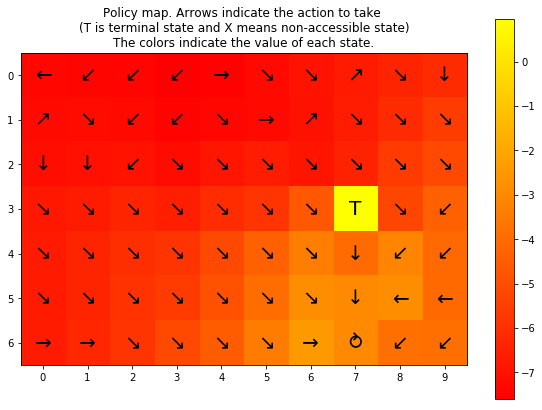

In [5]:
# Plot the value map and the policy
vals=[]
actions=[]
action_dict = {0: "↑",
               1: "→",
              2: "↓",
              3: "←",
              4: "↗",
              5: "↖",
              6: "↙",
              7: "↘",
              8: "⥁",
              np.nan: "X"}
for i in range(7):
    for j in range(10):
        if (i,j) in agent.state_action_value:
            action, value = max(agent.state_action_value[(i,j)].items(), key=lambda x:x[1])
        else:
            value = np.nan
            action = np.nan
        vals.append(value)
        actions.append(action_dict[action])

action_map = np.array(actions).reshape([7,10])
values_map = np.array(vals).reshape([7, 10])
action_map[3,7] = "T"

plt.figure(figsize=(10, 7))
plt.imshow(values_map, cmap=plt.cm.autumn)
for i in range(7):
        for j in range(10):
            text = plt.text(j, i, action_map[i, j],
                           ha="center", va="center", color="k", size=20, alpha=1)
plt.xticks(range(10))
plt.title("Policy map. Arrows indicate the action to take \n"+\
          "(T is terminal state and X means non-accessible state)\n"+\
          "The colors indicate the value of each state.")
plt.colorbar()
plt.show()